## Metrics and evaluation - Bank Marketing Dataset

In this exercise you will create a classification model to predict whether a client will subscribe to a term deposit or not. You will evaluate the model using different metrics and techniques.

The dataset is hosted in [Kaggle](https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset), although originally published by [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/222/bank+marketing)
You can also download it manually and update the `path` variable to the appropriate directory in your local environment.

Run the following cell to download the dataset using `kagglehub` package.

In [1]:
import kagglehub
import pandas

# Download latest version
path = kagglehub.dataset_download("janiobachmann/bank-marketing-dataset")

print("Path to dataset files:", path)

/Users/hakkindavid/Documents/GitHub/computational-intelligence/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hakkindavid/Documents/GitHub/computational-intelligence/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/hakkindavid/.cache/kagglehub/datasets/janiobachmann/bank-marketing-dataset/versions/1


In [2]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer

In [3]:
# The `path` variable points to the directory of the downloaded files.
# We are interested in the `bank.csv` file specifically.
filepath = Path(path) / Path("bank.csv")

data = pd.read_csv(filepath)

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## EDA

Let's start by exploring the dataset and understanding the features and target variable.
Here is the list of all features in the dataset:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


Additionally, the description of the database in the UCI repository provides more context on each feature:

| Variable Name | Role | Type | Demographic | Description | Units | Missing Values |
|---------------|------|------|-------------|-------------|-------|----------------|
| age           | Feature | Integer | Age | | | no |
| job           | Feature | Categorical | Occupation | type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') | | no |
| marital       | Feature | Categorical | Marital Status | marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) | | no |
| education     | Feature | Categorical | Education Level | (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') | | no |
| default       | Feature | Binary | | has credit in default? | | no |
| balance       | Feature | Integer | | average yearly balance | euros | no |
| housing       | Feature | Binary | | has housing loan? | | no |
| loan          | Feature | Binary | | has personal loan? | | no |
| contact       | Feature | Categorical | | contact communication type (categorical: 'cellular','telephone') | | yes |
| day           | Feature | Date | | last contact day of the week | | no |
| month         | Feature | Date | | last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec') | | no |
| duration      | Feature | Integer | | last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. | | no |
| campaign      | Feature | Integer | | number of contacts performed during this campaign and for this client (numeric, includes last contact) | | no |
| pdays         | Feature | Integer | | number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted) | | yes |
| previous      | Feature | Integer | | number of contacts performed before this campaign and for this client | | no |
| poutcome      | Feature | Categorical | | outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') | | yes |
| deposit       | Target | Binary | | has the client subscribed a term deposit? | | |


### Target variable analysis

Our target variable is `deposit`, which indicates whether a client has subscribed to a term deposit or not.

Text(0.5, 1.0, "Distribution of target variable 'deposit'")

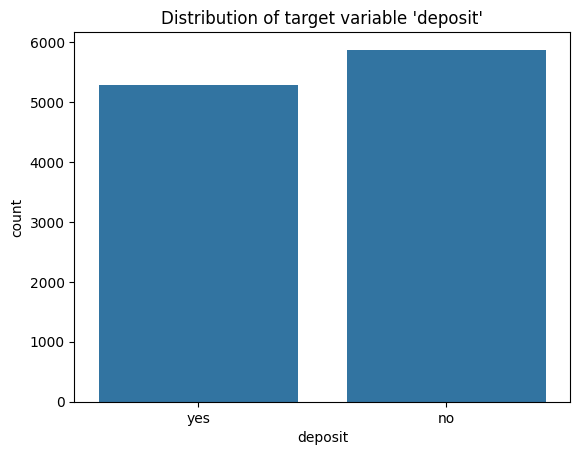

In [5]:
sns.countplot(data=data, x="deposit")
plt.title("Distribution of target variable 'deposit'")

### Feature analysis

Let's start by understanding the descriptive statistics of the dataset.

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.00,95.0
balance,11162.0,1528.538524,3225.413326,-6847.0,122.0,550.0,1708.00,81204.0
day,11162.0,15.658036,8.420740,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.330407,108.758282,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.00,58.0


We can also visualize the distribution of numerical features.

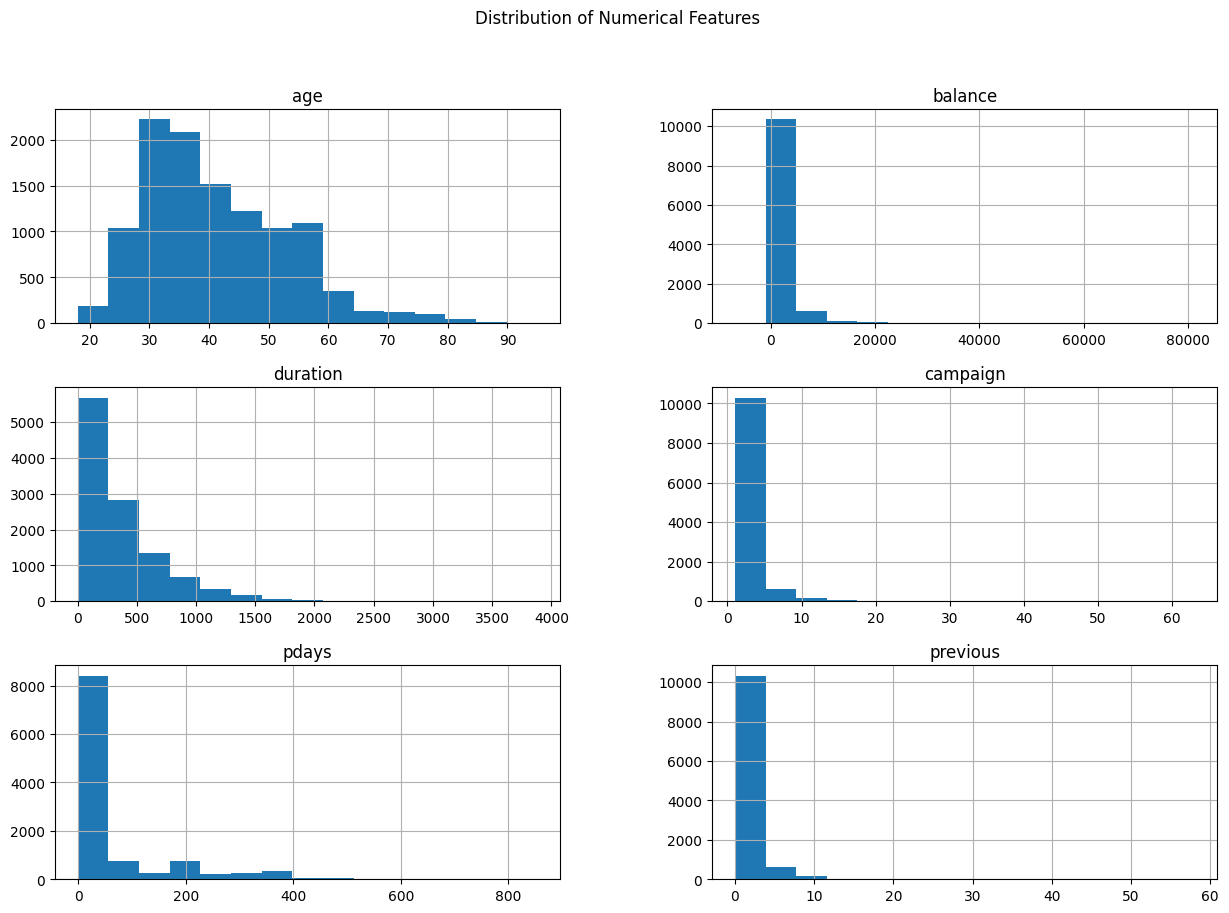

In [7]:
numerical_features = ["age", "balance", "duration", "campaign", "pdays", "previous"]

data[numerical_features].hist(bins=15, figsize=(15, 10))
plt.suptitle("Distribution of Numerical Features")
plt.show()

Let's also look at the distribution of categorical features. Note that we are considering day and month as categorical features for this analysis, since they have a limited number of unique values.

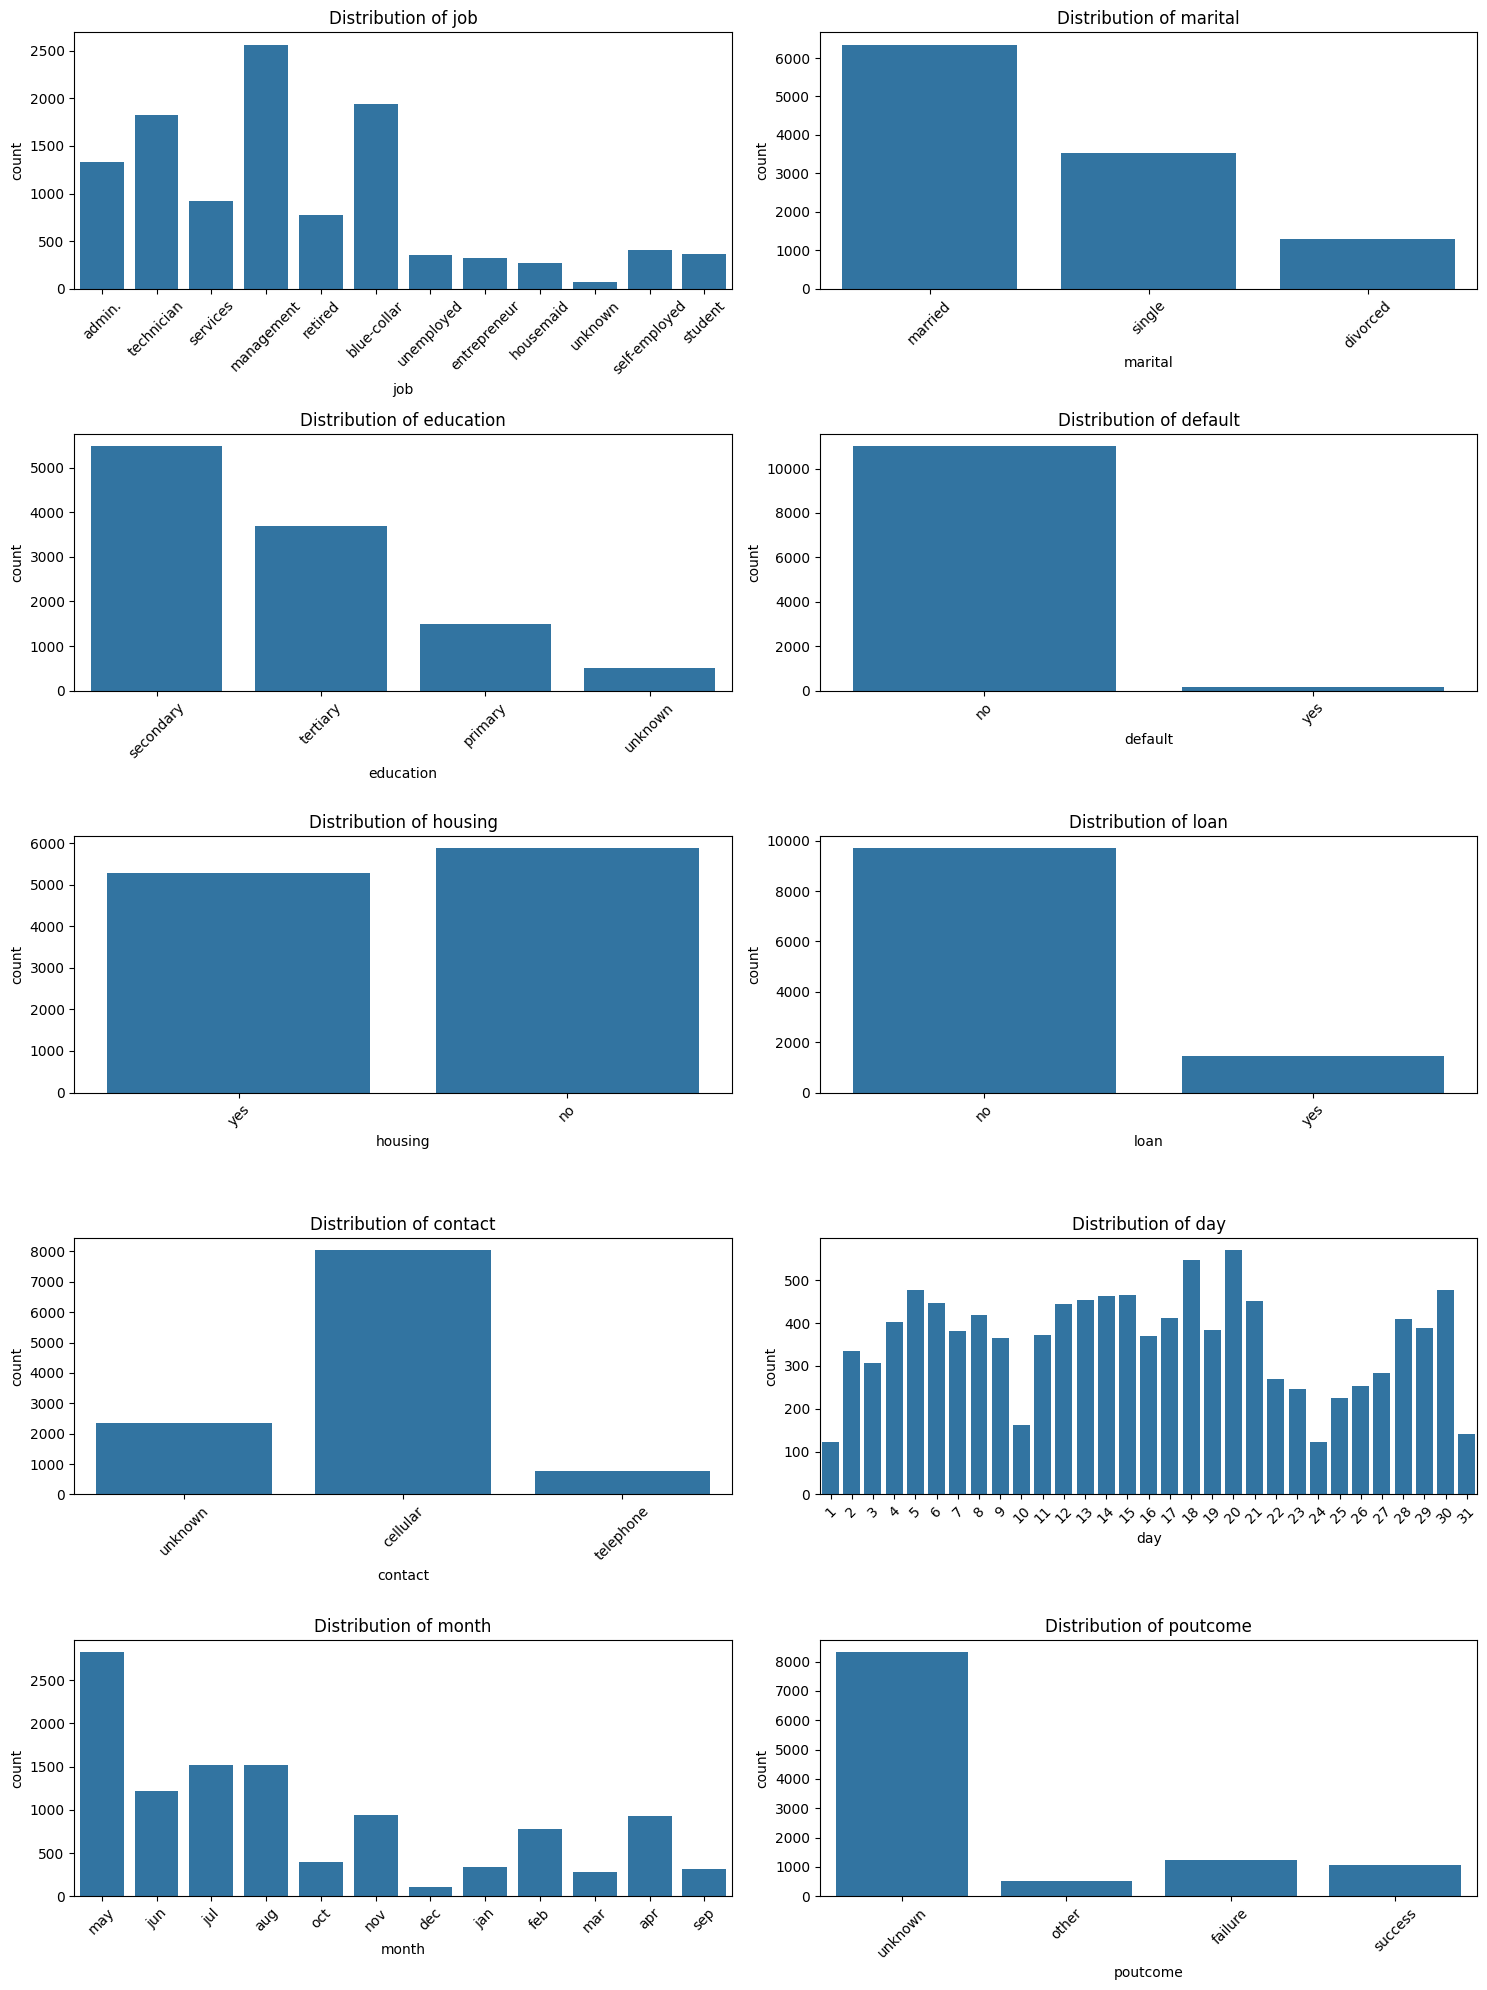

In [8]:
categorical_features = ["job", "marital", "education", "default", "housing", "loan", "contact", "day", "month",
                        "poutcome"]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for ax, feature in zip(axes.ravel(), categorical_features):
    sns.countplot(data=data, x=feature, ax=ax)
    ax.set_title(f"Distribution of {feature}")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

We can also explore the proportion of missing values in the dataset. From the description, we know that only `contact`, `pdays`, and `poutcome` have missing values. For `contact` and `poutcome`, 'unknown' is used to denote missing values, while for `pdays`, -1 indicates that the client was not previously contacted. Let's now verify the proportion of these missing values.

Additionally, `job` and `education` also have 'unknown' values, but they are not considered missing values in the dataset description, so we will not include them in this analysis.

In [9]:
missing_contact = (data['contact'] == 'unknown').mean() * 100
missing_pdays = (data['pdays'] == -1).mean() * 100
missing_poutcome = (data['poutcome'] == 'unknown').mean() * 100
missing_job = (data['job'] == 'unknown').mean() * 100
missing_education = (data['education'] == 'unknown').mean() * 100

print(f"Proportion of missing values in 'contact': {missing_contact:.2f}%")
print(f"Proportion of missing values in 'pdays': {missing_pdays:.2f}%")
print(f"Proportion of missing values in 'poutcome': {missing_poutcome:.2f}%")
print(f"Proportion of 'unknown' values in 'job': {missing_job:.2f}%")
print(f"Proportion of 'unknown' values in 'education': {missing_education:.2f}%")

Proportion of missing values in 'contact': 21.02%
Proportion of missing values in 'pdays': 74.57%
Proportion of missing values in 'poutcome': 74.59%
Proportion of 'unknown' values in 'job': 0.63%
Proportion of 'unknown' values in 'education': 4.45%


Let's also explore the relationship between some of the features and the target variable. For numerical features, we can use boxplots to visualize the distribution of the feature values for each class of the target variable.

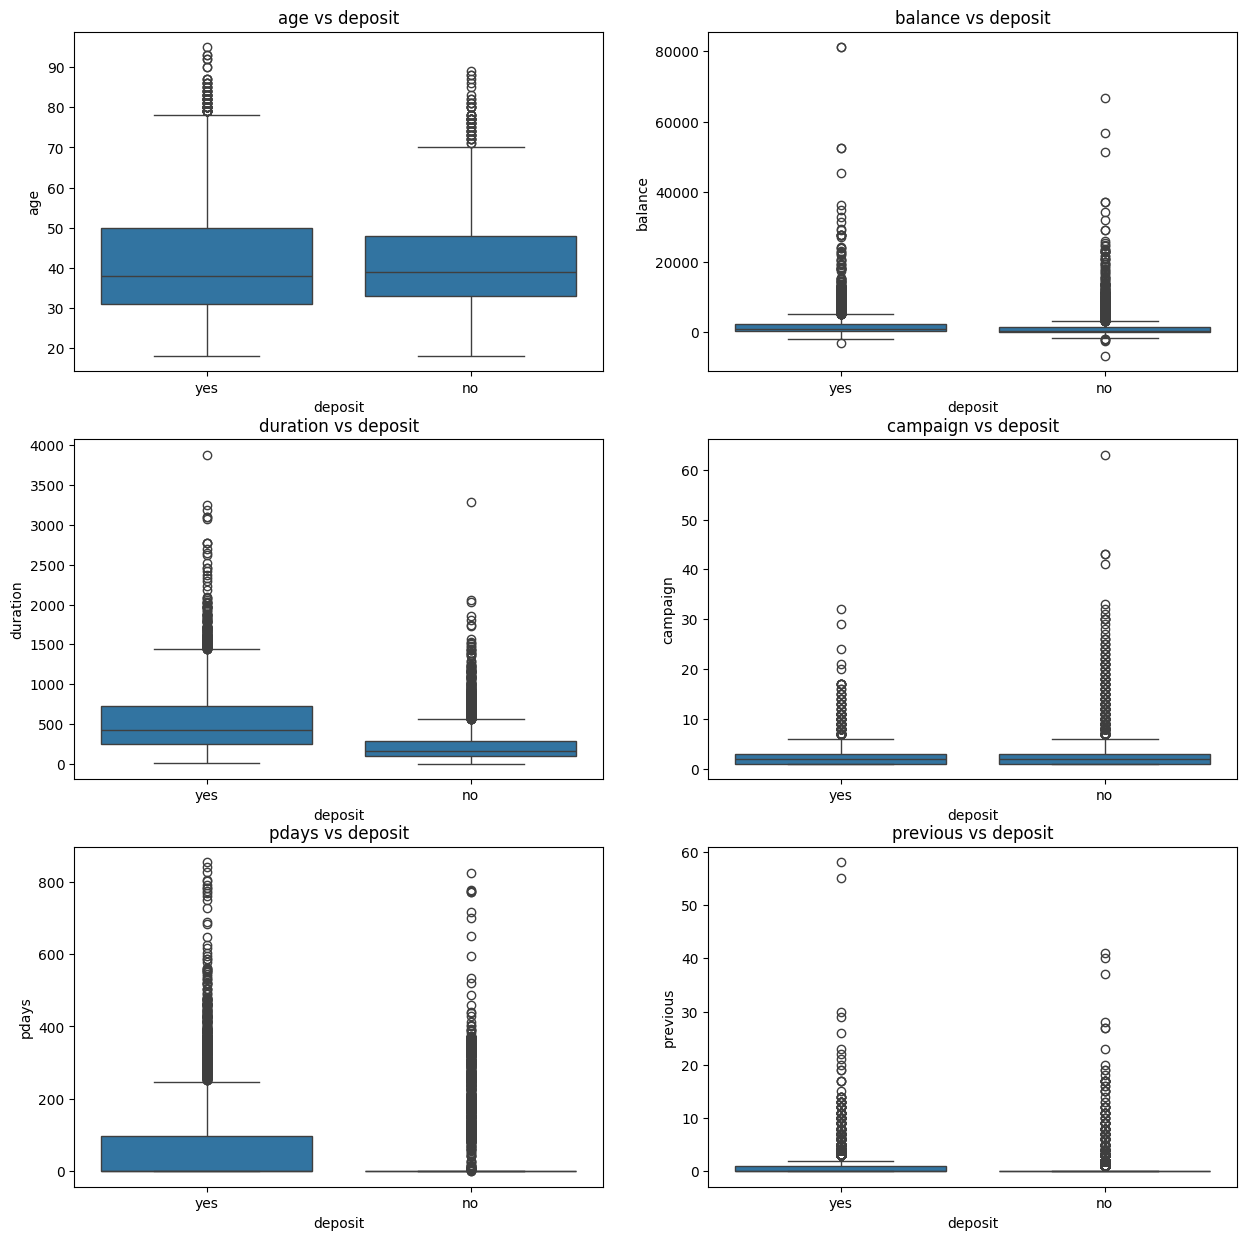

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

for ax, feature in zip(axes.ravel(), numerical_features):
    sns.boxplot(data=data, x="deposit", y=feature, ax=ax)
    ax.set_title(f"{feature} vs deposit")

We can also use countplots to visualize the relationship between categorical features and the target variable.

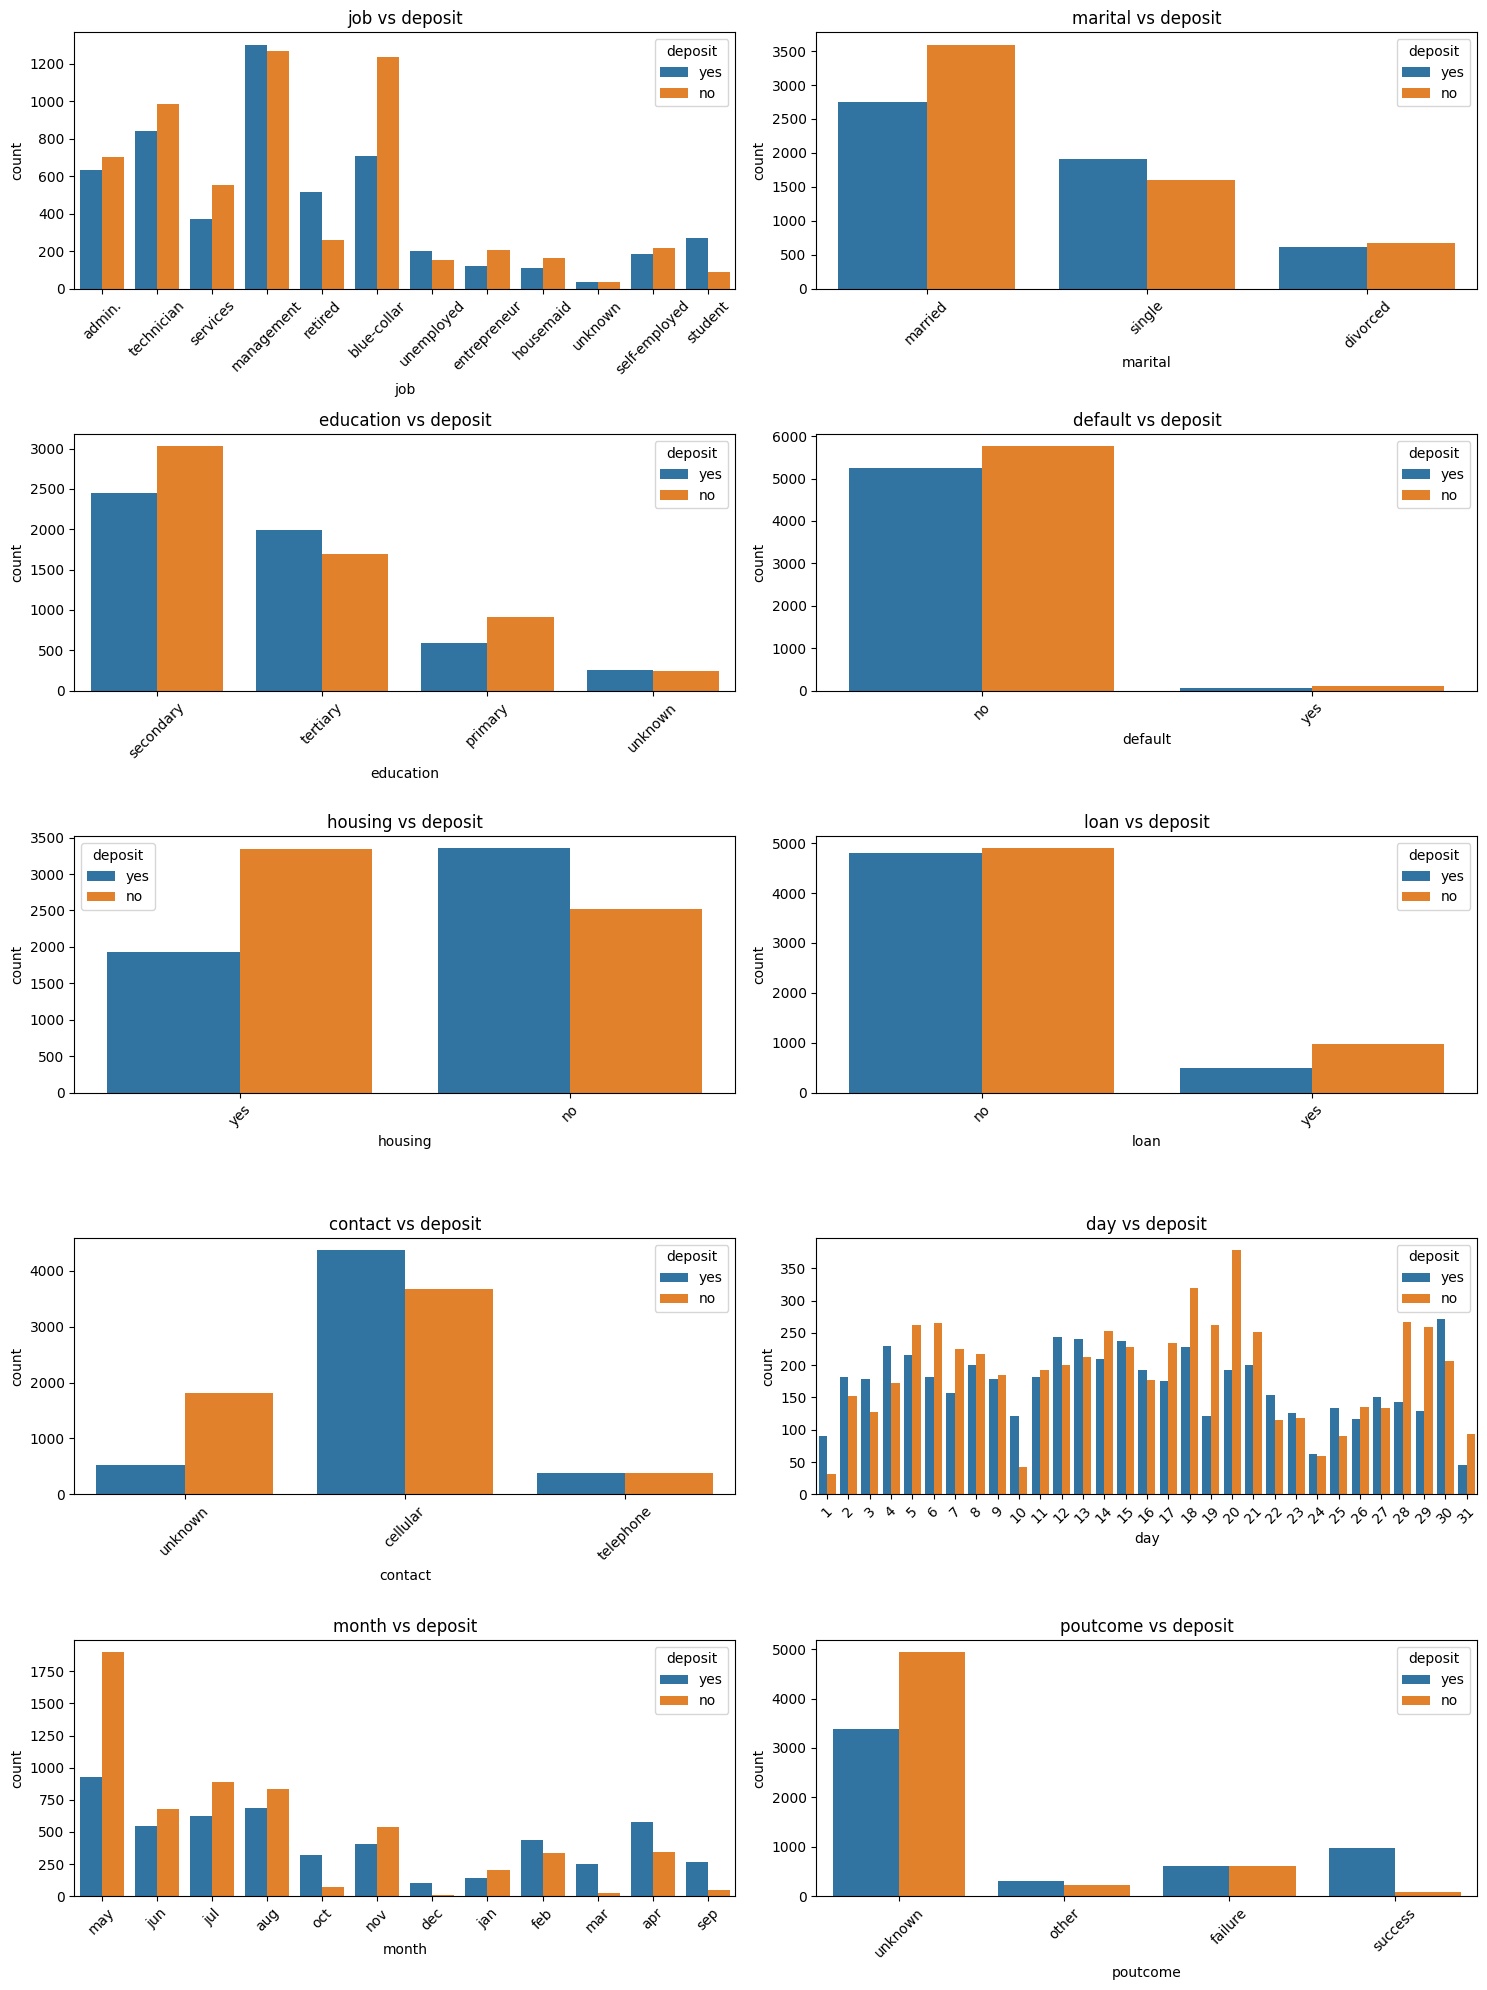

In [11]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for ax, feature in zip(axes.ravel(), categorical_features):
    sns.countplot(data=data, x=feature, hue="deposit", ax=ax)
    ax.set_title(f"{feature} vs deposit")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

Here we can derive a few insights from the visualizations:
- Clients with existing credits (`housing` and `loan`) are less likely to subscribe to a term deposit.
- Clients who previously subscribed to a term deposit (`poutcome`) are more likely to subscribe again. That said, the majority of clients have not been previously contacted, so this feature may not be very informative for our model.
- The duration of the last contact is much higher for clients who subscribed to a term deposit. However, as mentioned in the dataset description, this feature should be discarded for a realistic predictive model, since it is not known before a call is performed and it highly affects the target variable.
- The distribution of `balance` is also different for the two classes of the target variable, with clients who subscribed to a term deposit having a somewhat higher average balance. However, there are also some outliers in this feature, which may affect the performance of our model.
- Contact method also seems to have an impact on the target variable, with clients contacted via cellular being more likely to subscribe to a term deposit compared to those contacted via telephone. That said, there is also a significant proportion of missing values in this feature, which may affect its usefulness for our model. Also, cellular contact is more common in the dataset, so this feature may be somewhat imbalanced.

## Data preprocessing

Now that we have some understanding of the dataset, we can start with data preprocessing. We will create a pipeline to handle missing values, encode categorical features, and scale numerical features.

The first step is to separate the features and the target variable.

We will drop the `duration` feature as it is not known before a call is performed, and it highly affects the target variable, which would lead to an unrealistic predictive model. We are also dropping `pdays` and `poutcome` due to the high proportion of missing values, which may affect the performance of our model.

In [12]:
x = data.drop(columns=["deposit", "duration", "pdays", "poutcome"])
y = data["deposit"]

Before defining the preprocessing pipeline, we will perform a few simple transformations to the features:
- We will convert the `month` feature to a numerical representation, since it is an ordinal feature with a clear order (January to December).
- We will manually transform any column with `yes` and `no` values to binary 1 and 0, respectively, to simplify the encoding process in our pipeline. This includes our target variable `deposit`, which we will transform to a binary variable as well.
- For `education` and `job` features, we will replace 'unknown' values with the most frequent category in each feature, since 'unknown' is not a meaningful category and it may affect the performance of our model.
- For `education` specifically, we will manually encode the categories (primary, secondary, tertiary) to preserve the ordinal nature of this feature, which may be useful for our model.

Since these transformations are simple and do not require fitting any parameters, we will perform them outside of our preprocessing pipeline for simplicity. However, in a real-world scenario, it would be better to include all transformations in the pipeline to ensure that they are applied consistently to both the training and testing data.

In [13]:
y = y.map({"yes": 1, "no": 0})

x["month"] = x["month"].map({
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
})

binary_columns = ["default", "housing", "loan"]
for col in binary_columns:
    x[col] = x[col].map({"yes": 1, "no": 0})

x["education"] = x["education"].replace("unknown", x["education"].mode()[0])
x["job"] = x["job"].replace("unknown", x["job"].mode()[0])

x["education"] = x["education"].map({
    'primary': 1,
    'secondary': 2,
    'tertiary': 3,
})

We can now split the dataset into training and testing sets.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Now, let's define our preprocessing pipeline. For numerical features, we will impute missing values with the median and apply a power transformation to reduce skewness. For categorical features, we will impute missing values with the most frequent category and apply one-hot encoding. We will also set `remainder="passthrough"` in the `ColumnTransformer` to ensure that any columns not specified in the transformers are passed through without transformation (in this case, there should not be any, but it's a good practice to include this parameter). Additionally, we will set `verbose_feature_names_out=False` to get more readable feature names after transformation.

In [15]:
preprocessing = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("num", make_pipeline(SimpleImputer(strategy="median"), PowerTransformer()),
             ["age", "balance", "campaign", "previous"]),
            ("cat", make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")),
             ["marital", "contact", "job"])
        ],
        remainder="passthrough",
        verbose_feature_names_out=False
    )
)

Let's transform the training data using our preprocessing pipeline and take a look at the transformed features. Note that the output of the `ColumnTransformer` will be a NumPy array, so we will convert it back to a DataFrame for better readability, using the feature names generated by the transformers.

In [16]:
# X_train = preprocessing.fit_transform(X_train)
# feature_names = preprocessing.named_steps["columntransformer"].get_feature_names_out()
# X_train = pd.DataFrame(X_train, columns=feature_names)
# X_train.head()

Let's repeat the same transformation for the testing data. Note that we will use `transform` instead of `fit_transform` to ensure that the same transformations are applied to the testing data as were learned from the training data.

In [17]:
# X_test = preprocessing.transform(X_test)
# X_test = pd.DataFrame(X_test, columns=feature_names)
# X_test.head()

He comentado estas líneas porque el pipeline que utilizaremos más adelante con el pre-processing ya va a incluir esa transformación a los datos.

## Model training and evaluation

Instructions: Complete this exercise by training a classification model on the preprocessed training data and evaluating its performance on the testing data using appropriate metrics such as accuracy, precision, recall, and F1-score.

Try with at least 3 different classification algorithms (e.g., Logistic Regression, Random Forest, Support Vector Machine) and compare their performance. For each of them, use GridSearchCV to find the best hyperparameters and report the results.

Lastly, compare the performance of the models and, for the best one (based on your chosen evaluation metric), display a confusion matrix and a classification report to analyze the results in more detail. 

### Defining objective metrics

Como cliente de una institución financiera que no me deja en paz con el tema de aceptar un crédito, me pongo a reflexionar con bastante frialdad cómo es que se supone que me seleccionan para las llamadas y creo entender que la pregunta técnica no es qué modelo clasifica mejor, sino qué modelo ordena mejor a los clientes según su probabilidad real de, en este caso, conversión, pero en general sería de aceptar el crédito, minimizando los contactos inútiles, es decir, las llamadas. Por eso, la métrica de exactitud, accuracy, queda descartada casi de inmediato. En este escenario, la clase positiva, es decir, acepta, y la clase negativa, o bien rechaza, están desproporcionadas y desbalanceadas de una forma absurda; o sea, la mayor parte, el grueso de los contactos, terminan en rechazo. El grueso de nuestro universo de posibles clientes rechaza o no acepta la propuesta del crédito y demás. Entonces, en escenarios con desbalance de clases, un modelo trivial que prediga “no acepta” para todo puede alcanzar una exactitud elevadísima y, sin embargo, para el negocio, para la institución financiera, tiene una utilidad de negocio nula. El F1 score tampoco es necesariamente óptimo como métrica de optimización primaria, porque fija implícitamente un umbral de decisión y fuerza un equilibrio entre precisión y recall que puede no coincidir con la política operativa real de esta campaña. En marketing directo, es decir, llamando, rara vez se contacta al 100 % de la base o de nuestro universo de clientes, sino que se ordena a los clientes por propensión a aceptar y se selecciona un subconjunto según el presupuesto disponible. Por lo tanto, lo que realmente nos interesa es la calidad del ranking probabilístico más que una decisión binaria rígida. En ese contexto, la métrica que mejor captura esta lógica es el average precision, es decir, el área bajo la curva de precision-recall. A diferencia del ROC AUC, que puede verse artificialmente alto cuando la clase negativa domina ampliamente (porque sí es claro que la mayoría va a rechazar), la curva precision-recall se concentra exclusivamente en el comportamiento del modelo sobre la clase positiva. La precisión penaliza directamente los falsos positivos, que en este caso serían las llamadas innecesarias a clientes que van a rechazar, ejemplo: yo, y el recall cuantifica la capacidad de capturar clientes realmente interesados. El average precision integra ambos a lo largo de todos los posibles umbrales, evaluando la calidad del ordenamiento de probabilidades sin imponer de antemano un punto de corte. Optimizar average precision en GridSearchCV tiene varias implicaciones técnicas. Primero que nada, obliga a que los modelos produzcan probabilidades bien diferenciadas entre clientes de alta y de baja propensión a aceptar. No basta con separar linealmente las clases; estas deben asignar puntajes calibrados que permitan priorizar a los clientes. Segundo, se desplaza la atención del simple acierto puntual hacia la estructura global del ranking, que es precisamente como se busca hacer en producción: se selecciona al top K de clientes por probabilidad estimada hasta agotar el presupuesto.

#### En tanto, elijo "average precision"

### Training and evaluating different models

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

#### Model 1 - Regresión Logística

In [19]:
pipe_lr = Pipeline([
    ("preproc", preprocessing),
    ("clf", LogisticRegression(solver="saga", max_iter=5000, random_state=42))
])

param_grid_lr = {
    "clf__penalty": ["l2"],
    "clf__C": [0.01, 0.1, 1.0, 10.0],
    "clf__class_weight": [None, "balanced"]
}

gs_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring="average_precision", n_jobs=-1, return_train_score=True)

gs_lr.fit(X_train, y_train)

/Users/hakkindavid/Documents/GitHub/computational-intelligence/.venv/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        Pipeline(steps=[('columntransformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('num',
                                                                                          Pipeline(steps=[('simpleimputer',
                                                                                                           SimpleImputer(strategy='median')),
                                                                                                          ('powertransformer',
                                                                                                           PowerTransformer())]),
                                                                                          ['age',
                                                                                           'balance',
                                                                                           'campaign',
                                                                                           'previous']),
                                                                                         ('cat',
                                                                                          Pipeline(steps=[('simpleimputer',
                                                                                                           Simpl...
                                                                                                          ('onehotencoder',
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['marital',
                                                                                           'contact',
                                                                                           'job'])],
                                                                           verbose_feature_names_out=False))])),
                                       ('clf',
                                        LogisticRegression(max_iter=5000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1.0, 10.0],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__penalty': ['l2']},
             return_train_score=True, scoring='average_precision')

#### Model 2 - Random Forest

In [20]:
pipe_rf = Pipeline([
    ("preproc", preprocessing),
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid_rf = {
    "clf__n_estimators": [100, 300],
    "clf__max_depth": [None, 10, 30],
    "clf__min_samples_split": [2, 5],
    "clf__class_weight": [None, "balanced"]
}

gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring="average_precision", n_jobs=-1, return_train_score=True)

gs_rf.fit(X_train, y_train)

/Users/hakkindavid/Documents/GitHub/computational-intelligence/.venv/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        Pipeline(steps=[('columntransformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('num',
                                                                                          Pipeline(steps=[('simpleimputer',
                                                                                                           SimpleImputer(strategy='median')),
                                                                                                          ('powertransformer',
                                                                                                           PowerTransformer())]),
                                                                                          ['age',
                                                                                           'balance',
                                                                                           'campaign',
                                                                                           'previous']),
                                                                                         ('cat',
                                                                                          Pipeline(steps=[('simpleimputer',
                                                                                                           Simpl...
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['marital',
                                                                                           'contact',
                                                                                           'job'])],
                                                                           verbose_feature_names_out=False))])),
                                       ('clf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__class_weight': [None, 'balanced'],
                         'clf__max_depth': [None, 10, 30],
                         'clf__min_samples_split': [2, 5],
                         'clf__n_estimators': [100, 300]},
             return_train_score=True, scoring='average_precision')

#### Model 3 - Support Vector Machine

In [21]:
pipe_svc = Pipeline([
    ("preproc", preprocessing),
    ("clf", SVC(probability=True, random_state=42))
])

param_grid_svc = {
    "clf__C": [0.1, 1.0, 10.0],
    "clf__kernel": ["rbf"],
    "clf__gamma": ["scale", "auto"]
}

gs_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=5, scoring="average_precision", n_jobs=-1, return_train_score=True)

gs_svc.fit(X_train, y_train)

/Users/hakkindavid/Documents/GitHub/computational-intelligence/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/hakkindavid/Documents/GitHub/computational-intelligence/.venv/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        Pipeline(steps=[('columntransformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('num',
                                                                                          Pipeline(steps=[('simpleimputer',
                                                                                                           SimpleImputer(strategy='median')),
                                                                                                          ('powertransformer',
                                                                                                           PowerTransformer())]),
                                                                                          ['age',
                                                                                           'balance',
                                                                                           'campaign',
                                                                                           'previous']),
                                                                                         ('cat',
                                                                                          Pipeline(steps=[('simpleimputer',
                                                                                                           Simpl...rategy='most_frequent')),
                                                                                                          ('onehotencoder',
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['marital',
                                                                                           'contact',
                                                                                           'job'])],
                                                                           verbose_feature_names_out=False))])),
                                       ('clf',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1.0, 10.0],
                         'clf__gamma': ['scale', 'auto'],
                         'clf__kernel': ['rbf']},
             return_train_score=True, scoring='average_precision')

### Comparing model performance

In [22]:
from sklearn.metrics import average_precision_score, roc_auc_score

models = {
    "Regresión Logística": gs_lr,
    "Random Forest": gs_rf,
    "SVC": gs_svc
}

resultados = []

for nombre, gs in models.items():
    best = gs.best_estimator_
    best_index = gs.best_index_
    
    ap_cv = gs.best_score_
    ap_train = gs.cv_results_["mean_train_score"][best_index]
    ap_val = gs.cv_results_["mean_test_score"][best_index]
    
    y_proba = best.predict_proba(X_test)[:, 1]
    ap_test = average_precision_score(y_test, y_proba)
    roc_test = roc_auc_score(y_test, y_proba)
    
    resultados.append({
        "Modelo": nombre,
        "Mejores Hiperparámetros": gs.best_params_,
        "AP Entrenamiento (CV)": round(ap_train, 4),
        "AP Validación (CV)": round(ap_val, 4),
        "AP Prueba": round(ap_test, 4),
        "ROC AUC Prueba": round(roc_test, 4),
        "Brecha Overfitting (Train - CV)": round(ap_train - ap_val, 4)
    })

df_resultados = pd.DataFrame(resultados)

df_resultados = df_resultados.sort_values(by="AP Prueba", ascending=False)

df_resultados.reset_index(drop=True)


,Modelo,Mejores Hiperparámetros,AP Entrenamiento (CV),AP Validación (CV),AP Prueba,ROC AUC Prueba,Brecha Overfitting (Train - CV)
0,Random Forest,"{'clf__class_weight': None, 'clf__max_depth': ...",0.9982,0.7598,0.7759,0.7870,0.2384
1,SVC,"{'clf__C': 1.0, 'clf__gamma': 'auto', 'clf__ke...",0.8040,0.7577,0.7735,0.7853,0.0464
2,Regresión Logística,"{'clf__C': 1.0, 'clf__class_weight': None, 'cl...",0.6995,0.6940,0.7331,0.7470,0.0055


A primera vista, la elección parecería inclinarse hacia Random Forest, ya que exhibe el mayor *average precision* en entrenamiento, validación y prueba. Sin embargo, esa lectura superficial omite un detalle crucial: el rendimiento en entrenamiento roza prácticamente el valor máximo posible, mientras que en validación y prueba desciende de forma considerable. Esa discrepancia no es un matiz menor; indica que el modelo está capturando con excesiva fidelidad las particularidades del conjunto de entrenamiento. En términos prácticos, ha aprendido el patrón, pero también el ruido. La diferencia tan marcada entre entrenamiento y evaluación externa es un síntoma claro de sobreajuste. Aunque en el entorno actual parezca extraordinariamente potente, su capacidad de generalización es cuestionable, y en un escenario productivo su desempeño podría deteriorarse.

Support Vector Machine presenta un perfil distinto. Sus valores de *average precision* no alcanzan el máximo observado en Random Forest, pero se mantienen consistentes: alrededor de 0.80 en entrenamiento, 0.75 en validación y 0.77 en prueba. La brecha entre estas métricas es reducida, lo que sugiere un aprendizaje más equilibrado. No intenta exprimir el conjunto de entrenamiento hasta el límite, sino que conserva una relación más sana entre ajuste y generalización. Esa estabilidad es, en este contexto, un indicador de fiabilidad.

La regresión logística, por su parte, muestra una estabilidad aún mayor: entrenamiento, validación y prueba presentan valores muy próximos entre sí. Es el modelo más conservador y el que menos evidencia de sobreajuste manifiesta. No obstante, esa misma prudencia se traduce en un rendimiento inferior respecto a las alternativas. Su consistencia es innegable, pero su capacidad predictiva resulta limitada frente a SVC. En consecuencia, aunque es el modelo más estable en sentido estricto, no ofrece el mejor equilibrio entre desempeño y generalización.

#### Bajo esta evaluación conjunta (rendimiento absoluto y estabilidad), elijo Support Vector Machine.

### Best model analysis

In [23]:
best_svc = gs_svc.best_estimator_
y_pred = best_svc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(
    cm,
    index=["Real 0", "Real 1"],
    columns=["Predicho 0", "Predicho 1"]
)

report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

df_params = pd.DataFrame(
    list(best_svc.get_params().items()),
    columns=["Hiperparámetro", "Valor"]
)

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

In [24]:
df_params

,Hiperparámetro,Valor
0,memory,None
1,steps,"[(preproc, (ColumnTransformer(remainder='passthrough',\n transformers=[('num',\n Pipeline(steps=[('simpleimputer',\n SimpleImputer(strategy='median')),\n ('powertransformer',\n PowerTransformer())]),\n ['age', 'balance', 'campaign', 'previous']),\n ('cat',\n Pipeline(steps=[('simpleimputer',\n SimpleImputer(strategy='most_frequent')),\n ('onehotencoder',\n OneHotEncoder(handle_unknown='ignore'))]),\n ['marital', 'contact', 'job'])],\n verbose_feature_names_out=False))), (clf, SVC(gamma='auto', probability=True, random_state=42))]"
2,transform_input,None
3,verbose,False
4,preproc,"(ColumnTransformer(remainder='passthrough',\n transformers=[('num',\n Pipeline(steps=[('simpleimputer',\n SimpleImputer(strategy='median')),\n ('powertransformer',\n PowerTransformer())]),\n ['age', 'balance', 'campaign', 'previous']),\n ('cat',\n Pipeline(steps=[('simpleimputer',\n SimpleImputer(strategy='most_frequent')),\n ('onehotencoder',\n OneHotEncoder(handle_unknown='ignore'))]),\n ['marital', 'contact', 'job'])],\n verbose_feature_names_out=False))"
5,clf,"SVC(gamma='auto', probability=True, random_state=42)"
6,preproc__memory,None
7,preproc__steps,"[(columntransformer, ColumnTransformer(remainder='passthrough',\n transformers=[('num',\n Pipeline(steps=[('simpleimputer',\n SimpleImputer(strategy='median')),\n ('powertransformer',\n PowerTransformer())]),\n ['age', 'balance', 'campaign', 'previous']),\n ('cat',\n Pipeline(steps=[('simpleimputer',\n SimpleImputer(strategy='most_frequent')),\n ('onehotencoder',\n OneHotEncoder(handle_unknown='ignore'))]),\n ['marital', 'contact', 'job'])],\n verbose_feature_names_out=False))]"
8,preproc__transform_input,None
9,preproc__verbose,False


In [25]:
df_cm

,Predicho 0,Predicho 1
Real 0,1024,142
Real 1,448,619


In [26]:
df_report

,precision,recall,f1-score,support
0,0.695652,0.878216,0.776346,1166.000000
1,0.813403,0.580131,0.677243,1067.000000
accuracy,0.735781,0.735781,0.735781,0.735781
macro avg,0.754528,0.729174,0.726794,2233.000000
weighted avg,0.751918,0.735781,0.728991,2233.000000


El modelo seleccionado es un Support Vector Machine clasificador con kernel RBF, C igual a 1.0 y gamma igual a auto, una configuración que le permite flexibilidad, aunque no se va a los extremos. No es agresivamente regularizado ni presenta penalización débil. El valor de C equilibra la tolerancia al error con la complejidad del límite de decisión. El kernel que se eligió, según he investigado, permite capturar relaciones no lineales en los datos, algo que una regresión logística, por ejemplo, no podría modelar con la misma expresividad. Al marcar la bandera de probability true, se confirma que el modelo fue ajustado pensando en las métricas basadas en probabilidades, coherente con el uso previo que describimos necesario de average precision. La matriz de confusión, como se muestra a continuación, tiene 1024 verdaderos negativos, es decir, 1024 llamadas que no se van a hacer porque esta gente hubiese rechazado el préstamo o el crédito, y 619 verdaderos positivos, es decir, 619 llamadas que logran concretar el crédito porque llaman a la persona adecuada. Frente a 142 falsos positivos, es decir, 142 personas que fueron llamadas y que rechazaron el préstamo, y 448 falsos negativos, es decir, que no se les llamó, pero si de haberse les llamado hubieran aceptado. Esto revela un comportamiento bastante asimétrico, es decir, el modelo identifica con mayor facilidad la clase 0, es decir, la clase de aquellos que rechazarían el crédito respecto de la clase 1 o quienes lo aceptarían. Esa simetría se confirma en el reporte de clasificación. Para la clase 0, el recall es alto, de 0.878, lo que indica que detecta correctamente la mayoría de los negativos reales, lo que ahorra bastantes costos operativos. Para la clase 1, es decir, quienes aceptan el crédito, la precisión es relativamente elevada, 0.813, pero el recall desciende a 0.58, lo que significa que pierde una proporción considerable de positivos reales, casi la mitad. La exactitud global de 0.736 es un valor consistente con los promedios macro y ponderado, lo que sugiere que no se está sesgando de forma extrema hacia una sola clase. Sin embargo, el punto central no es la exactitud o accuracy. Si no el equilibrio entre precisión y recall en un problema donde previamente priorizamos la calidad del ranking probabilístico. En este sentido, el modelo mantiene un desempeño coherente, ya que no presenta señales de sobreajuste y conserva estabilidad entre métricas. Se elige este modelo porque ofrece el mejor compromiso entre capacidad de generalización y poder predictivo. Respecto a Random Forest, evita la brecha producida entre entrenamiento y validación. y frente a la regresión logística, incrementa la capacidad de capturar relaciones no lineales sin sacrificar la estabilidad. Su ventaja principal reside o radica en ese equilibrio. Es suficientemente complejo como para modelar patrones reales, pero se regula de forma implícita para evitar el ajuste excesivo que vimos en el otro modelo.

### Final remarks

Cerraremos este análisis recordando por qué elegimos como métrica prioritaria *Average Precision*. El problema está caracterizado por un desbalance entre clases y nos interesa particularmente el ranking probabilístico de que el cliente acepte el crédito. La elección no fue accidental, sino coherente con el objetivo del negocio, que es colocar estos préstamos.

Segundo, el modelo seleccionado no es el que alcanzó el número más alto de *Average Precision* en entrenamiento, sino el que mostró menor brecha entre entrenamiento y validación, a la par que mantuvo un valor alto. La matriz de confusión revela que el modelo Support Vector Machine clasificador tiene mayor capacidad para identificar correctamente la clase negativa que la positiva y que sacrifica *recall* en la clase positiva. Esto implica que, si el costo de perder positivos es alto, podría ser necesario ajustar el umbral de decisión. Es decir, el modelo es sólido, pero aún puede calibrarse.

Ningún modelo es definitivo. Podríamos explorar el ajuste fino de hiperparámetros, algunas técnicas de balanceo, la optimización del umbral o validación adicional en estos datos para reforzar su robustez, pero, en esencia, la idea es que nos evite el costo operativo de llamar a quienes rechazarán el préstamo o la tarjeta, o lo que sea que se esté tratando de colocar, y que busque predecir correctamente, la mayor parte del tiempo, cuándo una llamada va a tener éxito colocando el producto. El modelo elegido representa el mejor equilibrio entre estos dos criterios, aunque su comportamiento sugiere oportunidades de mejora según el costo asociado a errores de clasificación.